## ConvNeXt implementation
This is an implementation of the *ConvNeXt* architecture as proposed by *FAIR*.<br>
The original paper can be found here: https://github.com/facebookresearch/ConvNeXt<br>
The implementation below is inspired by: https://github.com/bamps53/convnext-tf

In [30]:
# imports
import numpy as np
import tensorflow as tf
import os
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import (Conv2D, Dense, DepthwiseConv2D,
                                     GlobalAveragePooling2D, Layer,
                                     LayerNormalization)

In [39]:
# loading the data
DIR_TRAIN = r'C:\Users\Maxi\Documents\Code\Project\Data\Use\Train'
DIR_TEST = r'C:\Users\Maxi\Documents\Code\Project\Data\Use\Test'
DIR_VALID = r'C:\Users\Maxi\Documents\Code\Project\Data\Use\Valid'

In [40]:
# show classes
os.listdir(DIR_TRAIN)

['CASPIAN TERN',
 'D-ARNAUDS BARBET',
 'DARK EYED JUNCO',
 'HOUSE FINCH',
 'OVENBIRD',
 'OYSTER CATCHER',
 'RED TAILED HAWK',
 'SWINHOES PHEASANT',
 'VIOLET GREEN SWALLOW',
 'WOOD DUCK']

In [41]:
# Data augmentation specifically for ConvNeXt as proposed by FAIR.

# store the bird names in a list
bird_names = [name for name in os.listdir(DIR_TRAIN)]

# dictionary for storing the images belonging to each bird class
bird_dic = {}

# for each bird class, get the list of jpgs
for name in bird_names:
  bird_dic[name] = [fn for fn in os.listdir('{}/{}'.format(DIR_TRAIN, name)) if fn.endswith('jpg')]

112.jpg


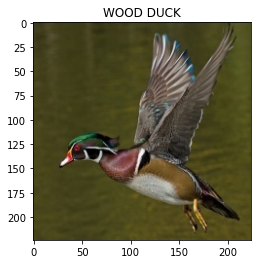

In [42]:
# use a random training image to demonstrate the augmentation techniques
def get_random_entry(dic):
    """
    Returns a random entry of a nested dictionary
    (dictionary with lists as values)
    
    Parameters:
    ----------
    dic : dictionary
        dictionary to get a random entry from
        
    Returns:
    -------
    a random entry label and a random value belonging to the entry
    """
    dic_as_list = list(dic.items())
    random_entry = random.choice(dic_as_list)
    random_label = random_entry[0]
    random_value = random.choice(random_entry[1])
    return random_label, random_value
    
sample_label, sample_image = get_random_entry(bird_dic)
fp = '{}/{}/{}'.format(DIR_TRAIN, sample_label, sample_image)
fn = image.load_img(fp, target_size = (224,224), color_mode='rgb')
plt.imshow(fn)
plt.title(sample_label)

print(sample_image)

In [ ]:
# function to show image before and after transformation

def show_transformation(original, augmented):
    """
    Compares the original with the augmented image.
    
    Parameters:
    ----------
    original : PIL.Image.Image
        image before augmentation
    augmented : PIL.Image.Image
        image after augmentation
    """
    fig = plt.figure(figsize=(7,7))
    plt.subplot(1,2,1)
    plt.title('Image before augmentation')
    plt.imshow(original)
    
    plt.subplot(1,2,2)
    plt.title('Image after augmentation')
    plt.imshow(augmented)

In [54]:
# some preprocessing
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_datagen = train_datagen.flow_from_directory(DIR_TRAIN,
                                                target_size=(224,224), 
                                                color_mode='rgb', 
                                                class_mode='categorical', 
                                                batch_size=16,
                                                shuffle=True)

test_datagen = test_datagen.flow_from_directory(DIR_TEST,
                                                target_size=(224,224),
                                                color_mode='rgb',
                                                class_mode='categorical',
                                                batch_size=16,
                                                shuffle=True)

valid_datagen = valid_datagen.flow_from_directory(DIR_VALID,
                                                target_size=(224,224), 
                                                color_mode='rgb', 
                                                class_mode='categorical', 
                                                batch_size=16,
                                                shuffle=True)

Found 1000 images belonging to 10 classes.
Found 50 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [55]:
# drop path function / class for randomly dropping entire blocks ("stochastic depth")

def drop_path(inputs, drop_prob, is_training):
    # copied from https://github.com/bamps53/convnext-tf/blob/master/models/convnext_tf.py who borrowed from https://github.com/rishigami/Swin-Transformer-TF/blob/main/swintransformer/model.py
    if (not is_training) or (drop_prob == 0.):
        return inputs

    # Compute keep_prob
    keep_prob = 1.0 - drop_prob

    # Compute drop_connect tensor
    random_tensor = keep_prob
    shape = (tf.shape(inputs)[0],) + (1,) * \
        (len(tf.shape(inputs)) - 1)
    random_tensor += tf.random.uniform(shape, dtype=inputs.dtype)
    binary_tensor = tf.floor(random_tensor)
    output = tf.math.divide(inputs, keep_prob) * binary_tensor
    return output


class DropPath(tf.keras.layers.Layer):
    # copied from https://github.com/bamps53/convnext-tf/blob/master/models/convnext_tf.py who borrowed from https://github.com/rishigami/Swin-Transformer-TF/blob/main/swintransformer/model.py
    def __init__(self, drop_prob=None):
        super().__init__()
        self.drop_prob = drop_prob

    def call(self, x, training=None):
        return drop_path(x, self.drop_prob, training)

In [56]:
# individual block class

class Block(Layer):
    # copied from https://github.com/bamps53/convnext-tf/blob/master/models/convnext_tf.py

    """ ConvNeXt Block (permutation from Pytorch to TF standards)
    DwConv -> Permute to (N, H, W, C); LayerNorm (channels_last) -> Linear -> GELU -> Linear; Permute back
    . N = number of images in the batch
    . H = height of the image
    . W = width of the image
    . C = number of channels of the image (3 for RGB)

    Args:
        dim (int): Number of input channels.
        drop_path (float): Stochastic depth rate. Default: 0.0
        layer_scale_init_value (float): Init value for Layer Scale. Default: 1e-6.
    """

    def __init__(self, dim, drop_path=0., layer_scale_init_value=1e-6, prefix=''):
        super().__init__()
        self.dwconv = DepthwiseConv2D(
            kernel_size=7, padding='same')  # depthwise conv
        self.norm = LayerNormalization(epsilon=1e-6)
        # pointwise/1x1 convs, implemented with linear layers
        self.pwconv1 = Dense(4 * dim)
        self.act = tf.keras.activations.gelu
        self.pwconv2 = Dense(dim)
        self.drop_path = DropPath(drop_path)
        self.dim = dim
        self.layer_scale_init_value = layer_scale_init_value
        self.prefix = prefix

    def build(self, input_shape):
        self.gamma = tf.Variable(
            initial_value=self.layer_scale_init_value * tf.ones((self.dim)),
            trainable=True,
            name=f'{self.prefix}/gamma')
        self.built = True

    def call(self, x):
        input = x
        x = self.dwconv(x)
        # x = x.permute(0, 2, 3, 1) # (N, C, H, W) -> (N, H, W, C)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        if self.gamma is not None:
            x = self.gamma * x
        # x = x.permute(0, 3, 1, 2) # (N, H, W, C) -> (N, C, H, W)

        x = input + self.drop_path(x)
        return x

In [57]:
class ConvNeXt(tf.keras.Model):
    # copied from https://github.com/bamps53/convnext-tf/blob/master/models/convnext_tf.py

    r""" ConvNeXt
        A Tensorflow keras impl of : `A ConvNet for the 2020s`  -
          https://arxiv.org/pdf/2201.03545.pdf
    Args:
        num_classes (int): Number of classes for classification head
        depths (tuple(int)): Number of blocks at each stage. Default: [3, 3, 9, 3]
        dims (int): Feature dimension at each stage. Default: [96, 192, 384, 768]
        include_top (bool): whether to add head or just use it as feature extractor. Default: True
        drop_path_rate (float): Stochastic depth rate. Default: 0.
        layer_scale_init_value (float): Init value for Layer Scale. Default: 1e-6.
        head_init_scale (float): Init scaling value for classifier weights and biases. Default: 1.
    """

    def __init__(self, num_classes=10,
                 depths=[3, 3, 9, 3], dims=[96, 192, 384, 768], include_top=True,
                 drop_path_rate=0., layer_scale_init_value=1e-6, head_init_scale=1.,
                 ):
        super().__init__()
        self.include_top = include_top
        self.downsample_layers = []  # stem and 3 intermediate downsampling conv layers
        stem = tf.keras.Sequential([
            Conv2D(dims[0], kernel_size=4, strides=4, padding='same'),
            LayerNormalization(epsilon=1e-6)]
        )
        self.downsample_layers.append(stem)
        for i in range(3):
            downsample_layer = tf.keras.Sequential([
                LayerNormalization(epsilon=1e-6),
                Conv2D(dims[i+1], kernel_size=2, strides=2, padding='same')]
            )
            self.downsample_layers.append(downsample_layer)

        self.stages = []  # 4 feature resolution stages, each consisting of multiple residual blocks
        dp_rates = [x for x in np.linspace(0, drop_path_rate, sum(depths))]
        cur = 0
        for i in range(4):
            stage = tf.keras.Sequential(
                [Block(dim=dims[i], drop_path=dp_rates[cur + j],
                       layer_scale_init_value=layer_scale_init_value, prefix=f'block{i}') for j in range(depths[i])]
            )
            self.stages.append(stage)
            cur += depths[i]

        if self.include_top:
            self.avg = GlobalAveragePooling2D()
            self.norm = LayerNormalization(epsilon=1e-6)  # final norm layer
            self.head = Dense(num_classes)
        else:
            self.avg = None
            self.norm = None
            self.head = None

    def forward_features(self, x):
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.stages[i](x)
        return x

    def call(self, x):
        x = self.forward_features(x)
        if self.include_top:
            x = self.avg(x)
            x = self.norm(x)
            x = self.head(x)
        return x

In [58]:
convnext = ConvNeXt(num_classes=10, depths=[3, 3, 9, 3], dims=[96, 192, 384, 768], include_top=True)

convnext.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
convnext.build(input_shape=(None, 224, 224, 3))
convnext.summary()

Model: "conv_ne_xt_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_40 (Sequential)   (None, 56, 56, 96)        4896      
_________________________________________________________________
sequential_41 (Sequential)   (None, 28, 28, 192)       74112     
_________________________________________________________________
sequential_42 (Sequential)   (None, 14, 14, 384)       295680    
_________________________________________________________________
sequential_43 (Sequential)   (None, 7, 7, 768)         1181184   
_________________________________________________________________
sequential_44 (Sequential)   (None, 56, 56, 96)        237888    
_________________________________________________________________
sequential_45 (Sequential)   (None, 28, 28, 192)       918144    
_________________________________________________________________
sequential_46 (Sequential)   (None, 14, 14, 384)      

In [59]:
convnext.fit(train_datagen, epochs=10, validation_data=valid_datagen)

Epoch 1/10
63/63 [==============================] - 52s 621ms/step - loss: 3.9853 - accuracy: 0.0960 - val_loss: 3.5155 - val_accuracy: 0.1000
Epoch 2/10
63/63 [==============================] - 37s 587ms/step - loss: 4.5839 - accuracy: 0.1000 - val_loss: 4.8145 - val_accuracy: 0.1000
Epoch 3/10
63/63 [==============================] - 37s 588ms/step - loss: 4.4849 - accuracy: 0.1100 - val_loss: 3.5343 - val_accuracy: 0.1000
Epoch 4/10
63/63 [==============================] - 37s 581ms/step - loss: 4.3896 - accuracy: 0.1010 - val_loss: 4.8951 - val_accuracy: 0.1000
Epoch 5/10
63/63 [==============================] - 36s 572ms/step - loss: 4.6925 - accuracy: 0.1060 - val_loss: 3.5189 - val_accuracy: 0.1000
Epoch 6/10
63/63 [==============================] - 35s 561ms/step - loss: 3.7514 - accuracy: 0.1000 - val_loss: 4.8819 - val_accuracy: 0.1000
Epoch 7/10
63/63 [==============================] - 36s 575ms/step - loss: 4.6451 - accuracy: 0.1000 - val_loss: 4.3990 - val_accuracy: 0.1000

__________

Premade Model

In [29]:
# load pre-trained model and configure depth and dimensions
# copied from https://github.com/bamps53/convnext-tf/blob/master/models/convnext_tf.py

model_url = {
    "convnext_tiny_224": "https://github.com/bamps53/convnext-tf/releases/download/v0.1/convnext_tiny_1k_224_ema.h5"
}

model_configs = dict(
    convnext_tiny=dict(
        depths=[3, 3, 9, 3],
        dims=[96, 192, 384, 768]
    )
)

In [37]:
# function to build model (we confine the model to the most basic pre-trained model since we have less classes)
# copied from https://github.com/bamps53/convnext-tf/blob/master/models/convnext_tf.py

def create_model(model_name='convnext_tiny_1k', input_shape=(224, 224), num_classes=10, include_top=True, pretrained=True, use_tpu=False, **kwargs):
    cfg = model_configs['_'.join(model_name.split('_')[:2])]
    print(cfg)
    net = ConvNeXt(num_classes, cfg['depths'], cfg['dims'], include_top, **kwargs)
    net(tf.keras.Input(shape=(*input_shape, 3)))
    if pretrained is True:
        url = model_url
        pretrained_ckpt = tf.keras.utils.get_file(
            f'{model_name}.h5', url, untar=False)
        if use_tpu:
            load_locally = tf.saved_model.LoadOptions(
                experimental_io_device='/job:localhost')
            net.load_weights(
                pretrained_ckpt, options=load_locally, skip_mismatch=True)
        else:
            net.load_weights(pretrained_ckpt, skip_mismatch=True, by_name=True)

    return net

In [38]:
# intiliase model
x = tf.zeros((1, 224, 224, 3), dtype=tf.float32)

model = create_model()
out = model(x) # (1, 1000)

{'depths': [3, 3, 9, 3], 'dims': [96, 192, 384, 768]}


AttributeError: 'dict' object has no attribute 'timeout'